# Covid Case Analysis

## 1. Cumulative COVID-19 Cases / Deaths Over Time by WHO Region
- EURO and AMRO regions have the highest cumulative cases/deaths, with EURO leading for the majority of the time period shown.
- The WPRO region shows a sharp increase in cumulative cases starting around late 2021 and continuing into 2022.

![Cumulative COVID-19 Cases](Cumulative%20COVID-19%20Cases.png)

![Cumulative COVID-19 Deaths](Cumulative%20COVID-19%20Deaths.png)


## 2. Total COVID-19 Cases per WHO Region
- Top three regions with highest total number of cases are EURO, WPRO, and AMRO.

![Total COVID-19 Cases per WHO Region](Total%20COVID-19%20Cases%20per%20WHO%20Region.png)


## 3. Infected Percentage by WHO Region for 2020 and 2021
- EURO and AMRO have the highest proportion of the infected population in both 2020 and 2021, aligning with the trend in total numbers.
- There is a noticeable increase in the infected percentage from 2020 to 2021 in both of these regions.
- However, the lower infected percentages in WPRO might indicate a relatively less severe level of infection in this region.
- Though WPRO has high total infection numbers, the infections in this region still seem to be under control, suggesting that more resources should be invested in EURO and AMRO instead.


![Infected Percentage by WHO Region for 2020 and 2021](Infected%20Percentage%20by%20WHO%20Region%20for%202020%20and%202021.png)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any, List

In [2]:
## class for data validations

class Validations:
    def __init__(self, df: pd.DataFrame, str_col: List[str], date_col: str = None):
        """
        Initialize the Validations object with the dataframe, string columns, and optional date column.
        """
        self.df = df
        self.str_col = str_col
        self.date_col = date_col
        
        
    def validate_date_column(self) -> None:
        """
        Validate that the date column is in the correct format (YYYY-MM-DD).
        """
        if self.date_col not in self.df.columns:
            raise ValueError(f"Date Column '{self.date_col}' Not Found")

        try:
            pd.to_datetime(self.df[self.date_col], format="%Y-%m-%d", errors='raise')
        except (TypeError, ValueError) as exc:
            raise ValueError(f"Date validation error in column '{self.date_col}': {exc}") from exc


    def check_missing_values(self) -> None:
        """
        Check if the dataset contains missing values in the specified column
        """
        # Use generator to save memory
        null_columns_gen = (col for col in self.df.columns if self.df[col].isnull().any())
        null_columns_list = list(null_columns_gen)
        if null_columns_list:
            raise ValueError(f"Missing values found in columns: {', '.join(null_columns_list)}")


    @staticmethod
    def validate_contains_comma(value) -> bool:
        """
        Check if the value contains a comma.
        """
        # Only check str values to prevent type errors
        return ',' in value if isinstance(value, str) else False


    def validate_thousand_separator(self, series: pd.Series) -> None:
        """
        Check if the series contains commas as thousands separator.
        """
        if series.map(self.validate_contains_comma).any():
            raise ValueError(f"Error: {series.name} contains commas or thousands separators.")


    def validate_dataset(self) -> None:
        """
        Validate the dataset by checking:
        - Specified columns are convertible to strings.
        - The date column is in the correct format, if provided.
        - The dataset contains no missing values.
        - Float or int columns do not include commas as thousand separators.
        """
        # Validate specified columns can be converted to strings
        missing_columns = [col for col in self.str_col if col not in self.df.columns]
        if missing_columns:
            raise ValueError(f'Missing columns in the DataFrame: {", ".join(missing_columns)}')

        # Validate data types and null values
        for col in self.str_col:
            try:
                self.df[col].astype('str')
            except KeyError:
                raise Exception(f'Column "{col}" does not exist in the DataFrame.')
            except Exception:
                raise Exception(f'Unable to convert "{col}" to str')

        # Check datetime format
        if self.date_col:
            self.validate_date_column()

        # Check null value
        self.check_missing_values()

        # Validate float or int columns for thousand separators
        for col in self.df.columns.difference(self.str_col):
            try:
                self.validate_thousand_separator(self.df[col])
            except ValueError as exc:
                raise Exception(f'Error in column "{col}": {exc}')



## Import Data

In [3]:
## Import country_codes

country_codes = pd.read_csv('country-codes.csv')\
                  .dropna(axis = 'index')

# Describe data
print(len(np.unique(country_codes['country_code_2d']))) # 248
# print(country_codes.info())
# print(country_codes.describe())


# Validate dataset
validator_codes = Validations(
    df = country_codes,
    str_col= ['country', 'country_code_2d', 'country_code_3d']
)

validator_codes.validate_dataset()

248


In [4]:
## Import country_population
country_population_data = pd.read_csv("country-population.csv")\
                            .drop(['Indicator Name','Indicator Code','Unnamed: 66'], axis=1)\
                            .dropna(axis = 'index')

# Describe data
print(len(np.unique(country_population_data['Country Code']))) # 264
# print(country_population_data.info())
# print(country_population_data.describe())


# Validate dataset
validator_population = Validations(
    df = country_population_data,
    str_col= ['Country Name', 'Country Code']
)

validator_population.validate_dataset()

264


In [5]:
## Import covid case data
covid_df = pd.read_csv("covid-data.csv")\
             .dropna(axis = 'index')

# Describe data
print(len(np.unique(covid_df['Country_code']))) # 236
# print(covid_df.info())
# print(covid_df.describe())


# Validate dataset
validator_covid = Validations(
    df = covid_df,
    str_col= ['Country_code', 'Country', 'WHO_region'],
    date_col= 'Date_reported'
)

validator_covid.validate_dataset()

236


## Exploratory Data Analysis

In [6]:
## Check inconsistent country data

@staticmethod
def find_inconsistency(series_1: pd.Series, series_2: pd.Series) -> set:
    """
    Find inconsistent country values between each dataset pair.
    """
    left_anti = set(series_1.unique()) - set(series_2.unique())
    right_anti = set(series_2.unique()) - set(series_1.unique())
    inconsistencies = left_anti.union(right_anti)

    print(f'Inconsistencies: {inconsistencies}')

    
find_inconsistency(country_codes['country_code_2d'], covid_df['Country_code'])
find_inconsistency(country_codes['country_code_3d'], country_population_data['Country Code'])

Inconsistencies: {'IO', 'SJ', 'HK', 'BQ', 'NF', 'HM', 'XK', 'UM', 'BV', 'CC', 'TW', 'XC', 'EH', 'AQ', 'XA', 'MO', 'XB', 'AX', 'CX', ' ', 'TF', 'GS'}
Inconsistencies: {'OSS', 'MIC', 'SSA', 'AIA', 'IDA', 'PSS', 'TEC', 'PRE', 'NFK', 'IOT', 'MSR', 'IDB', 'IBD', 'LIC', 'TSA', 'GUF', 'SST', 'TMN', 'AFW', 'CEB', 'SHN', 'EAR', 'CSS', 'VAT', 'WLF', 'FLK', 'TLA', 'ATA', 'EAP', 'PST', 'SPM', 'MTQ', 'REU', 'EAS', 'EUU', 'LDC', 'ARB', 'TKL', 'XKX', 'CXR', 'ESH', 'BVT', 'IDX', 'LTE', 'SGS', 'MEA', 'TEA', 'SSF', 'TSS', 'LMC', 'UMC', 'NAM', 'HMD', 'ECA', 'ALA', 'ATF', 'NIU', 'FCS', 'CHI', 'MNA', 'IBT', 'JEY', 'BES', 'PCN', 'MYT', 'PSE', 'WLD', 'NAC', 'EMU', 'ECS', 'LCN', 'SAS', 'HPC', 'OED', 'GGY', 'COK', 'AFE', 'LAC', 'LMY', 'HIC', 'TWN', 'GLP', 'SJM', 'UMI', 'CCK', 'BLM'}


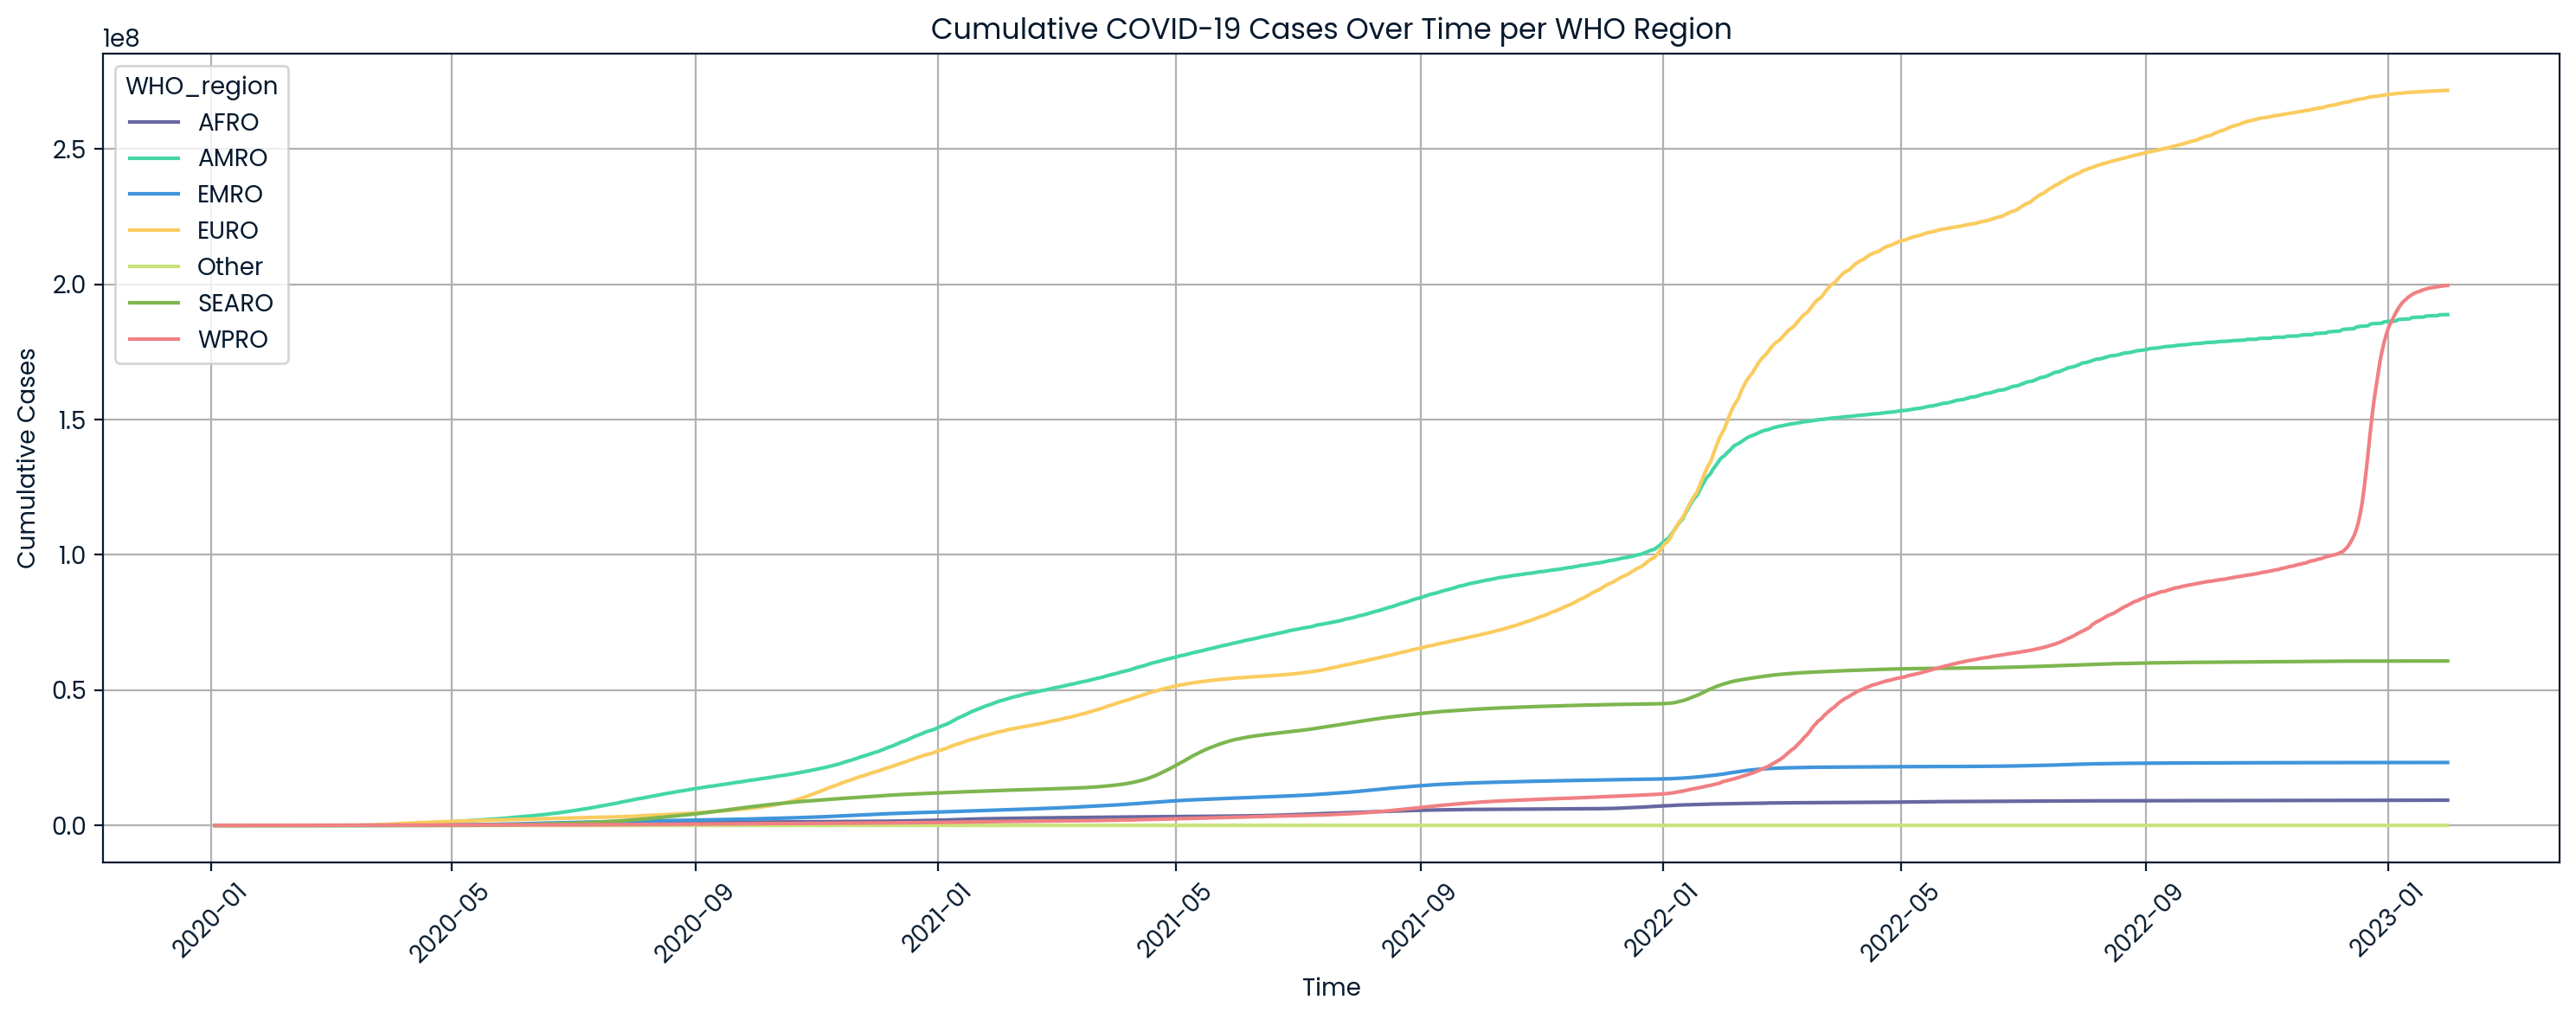

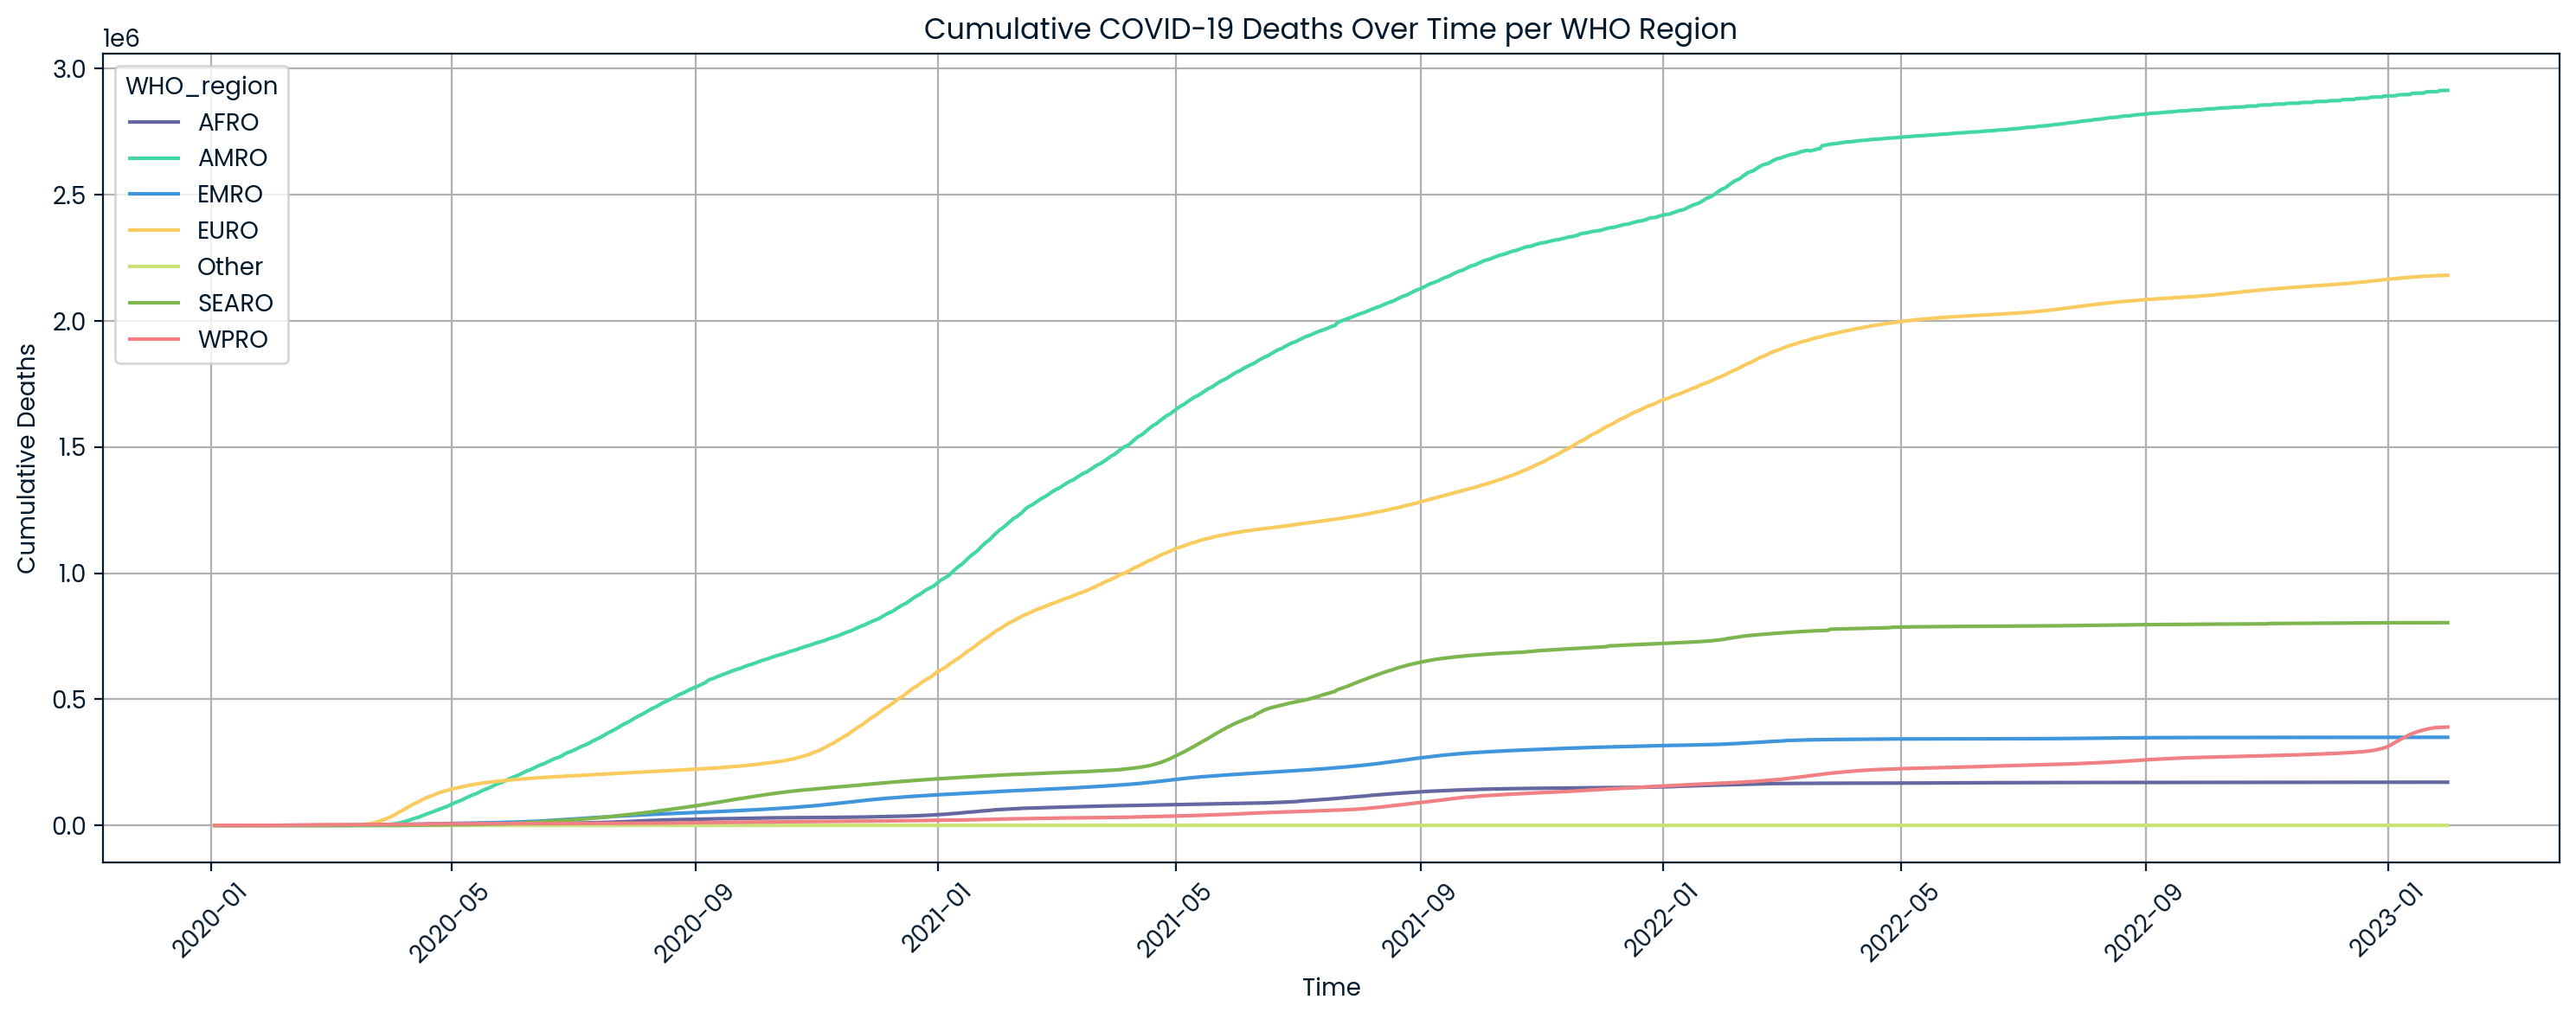

In [7]:
## Visualise cumulative case trends for each region

covid_df['Date_reported'] = pd.to_datetime(covid_df['Date_reported'], format='%Y-%m-%d')

covid_df_region_case = covid_df.groupby(['Date_reported','WHO_region'])['Cumulative_cases']\
                               .sum().reset_index()

plt.figure(figsize=(15, 6))
    
sns.lineplot(data=covid_df_region_case, x='Date_reported',y='Cumulative_cases',hue='WHO_region')

plt.title('Cumulative COVID-19 Cases Over Time per WHO Region')
plt.xlabel('Time')
plt.ylabel('Cumulative Cases')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()


## Visualise cumulative death trends for each region
covid_df_region_death = covid_df.groupby(['Date_reported','WHO_region'])['Cumulative_deaths']\
                                .sum().reset_index()

plt.figure(figsize=(15, 6))
    
sns.lineplot(data=covid_df_region_death, x='Date_reported',y='Cumulative_deaths',hue='WHO_region')

plt.title('Cumulative COVID-19 Deaths Over Time per WHO Region')
plt.xlabel('Time')
plt.ylabel('Cumulative Deaths')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

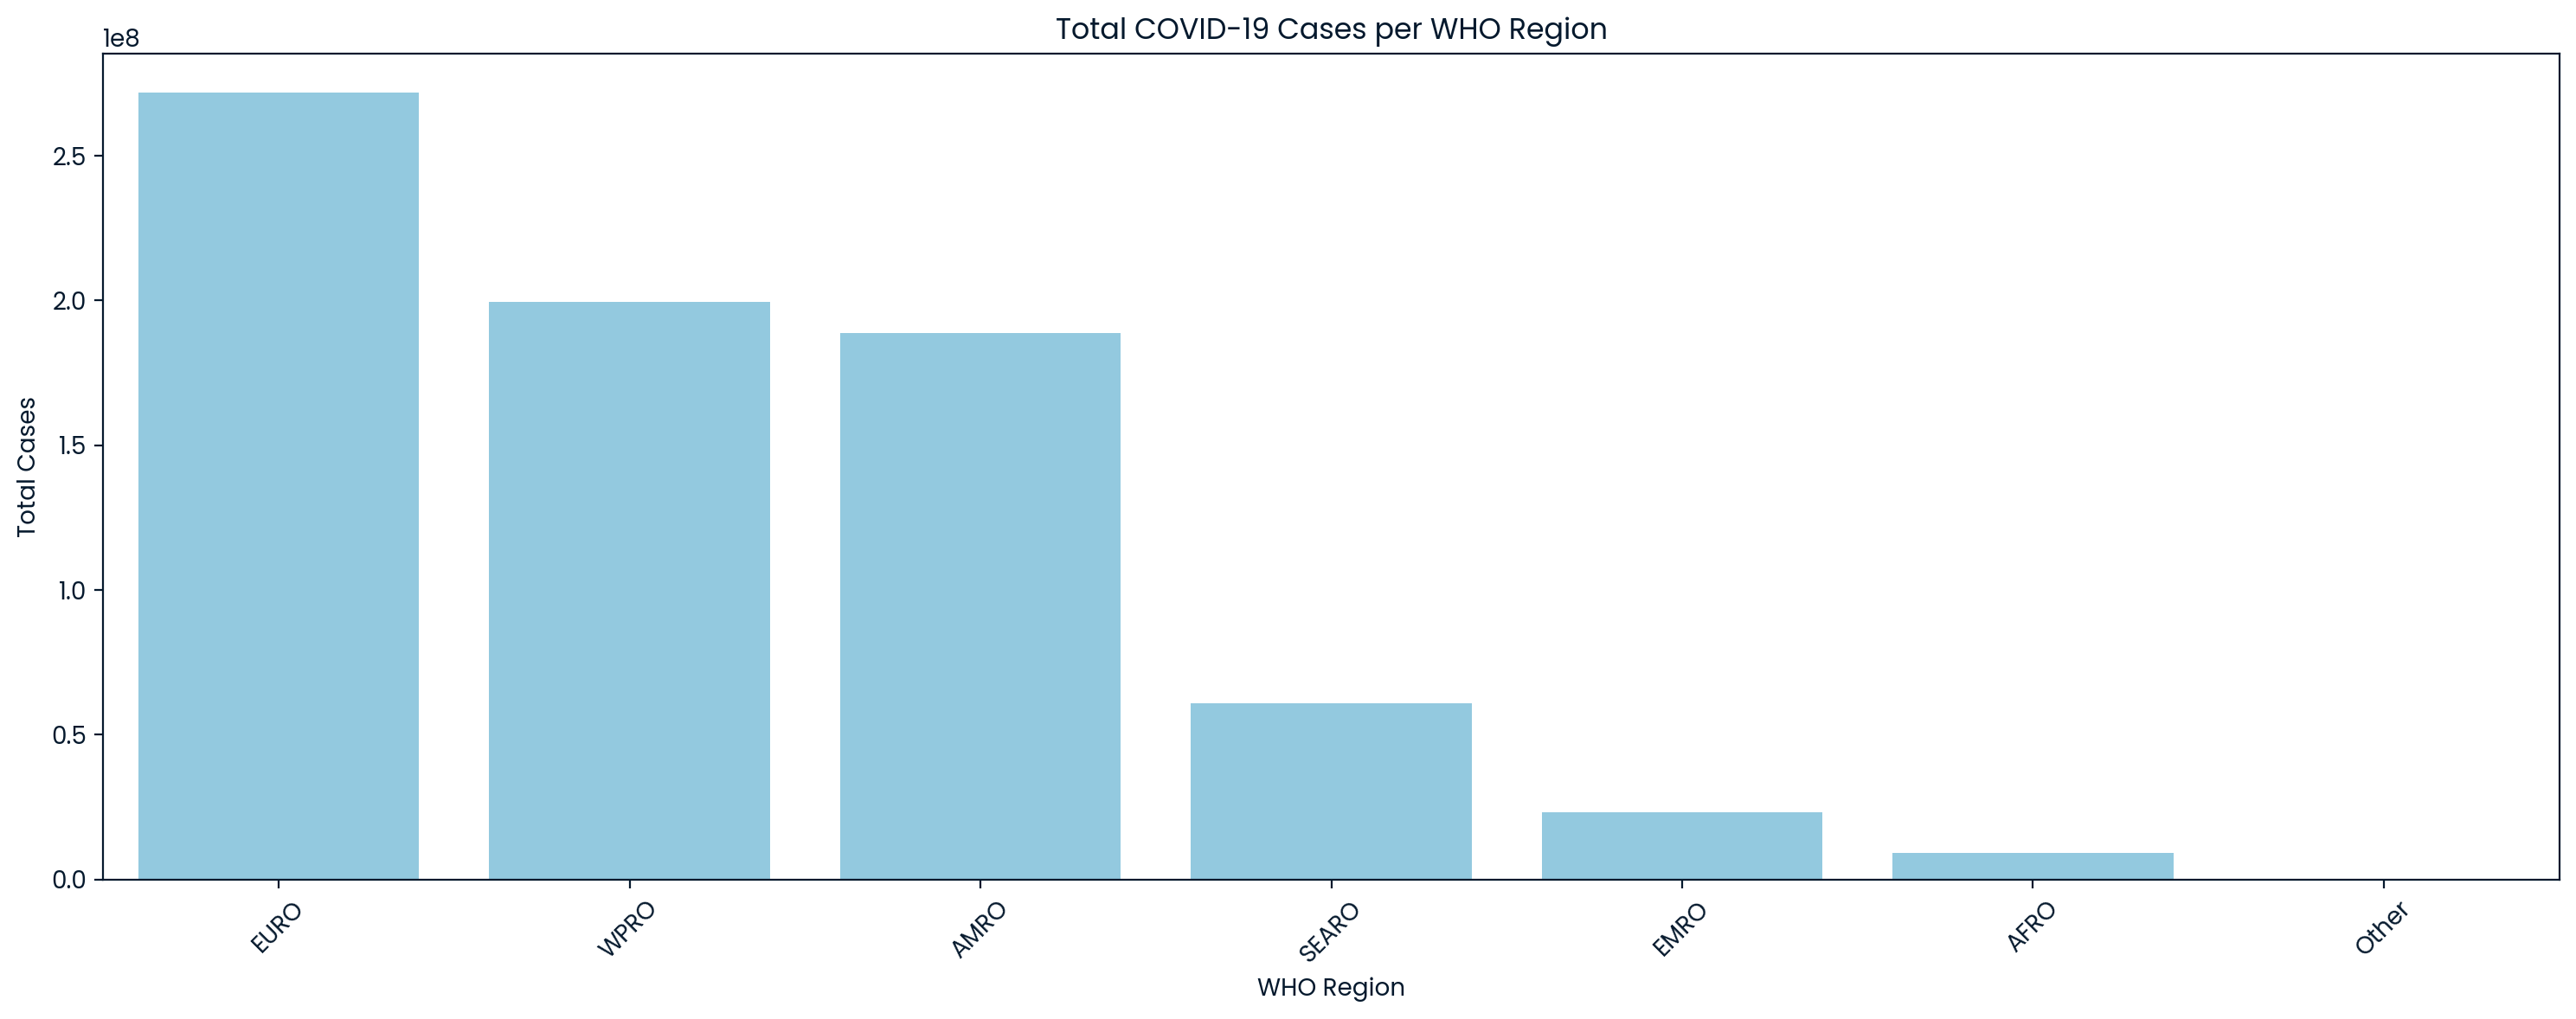

In [8]:
## Visualise total cumulative COVID-19 Cases per WHO Region
region_agg = covid_df.groupby('WHO_region')['New_cases']\
                    .sum()\
                    .reset_index()\
                    .sort_values(by='New_cases', ascending=False)

plt.figure(figsize=(15, 6))
sns.barplot(x='WHO_region', y='New_cases', data=region_agg, color='skyblue')

plt.title('Total COVID-19 Cases per WHO Region')
plt.xlabel('WHO Region')
plt.ylabel('Total Cases')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Assumption and validation

In [9]:
## Merge datasets
# inner join to prevent inconsistencies
coded_df = covid_df.merge(country_codes, 
                          left_on='Country_code', 
                          right_on='country_code_2d',
                          how='inner')\
                    .dropna(axis='index')\
                    .drop(['Country',
                           'country',
                           'country_code_2d'], 
                          axis=1)
                    

merged_df = coded_df.merge(country_population_data[['Country Code', '2020', '2021']], 
                           left_on='country_code_3d', 
                           right_on='Country Code',
                           how='inner')\
                    .dropna(axis='index')\
                    .drop(['country_code_3d',
                           'Country Code'],
                         axis=1)

# Add Year for filtering
merged_df['Date_reported'] = pd.to_datetime(merged_df['Date_reported'])
merged_df["Year"] = merged_df['Date_reported'].dt.year

# Describe cleaned dataset
print(len(np.unique(merged_df['Country_code']))) # 211 countries in total
# print(merged_df.groupby('Country_code')['Date_reported'].count().head(1)) # 1125 records per country
# print(merged_df.info())

211


In [11]:
## Calculate annual new cases per region

@staticmethod
def agg_annual_cases_by_region(df: pd.DataFrame, year_col: str, region_col: str, *populations: list) -> dict:
    """
    Aggregate daily data into annual data by region.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        year_col (str): The column name for the year.
        region_col (str): The column name for the region.
        populations (list): Additional arguments specifying the population of each year to aggregate.

    Returns:
        dict: A dictionary where the keys are years and the values are DataFrames containing the aggregated data.
    """
    annual_cases_by_region = {}
    
    for y in np.unique(df[year_col]):
        mask = (df[year_col] == y)
        
        # First aggregation to exclude populations to prevent incorrect population sum
        temp_df = df[mask].groupby([year_col,region_col,*populations])[['New_cases','New_deaths']]\
                          .sum()\
                          .reset_index()
        
        # Second aggregation to group by region and year
        annual_cases_by_region[y] = temp_df.groupby([year_col,region_col])[['New_cases','New_deaths',f'{y}']].sum().reset_index()
        
        annual_cases_by_region[y].rename(columns={'New_cases':f'Annual_cases_{y}',
                                                  'New_deaths':f'Annual_deaths_{y}'}, inplace=True)
        
    assert len(annual_cases_by_region.keys()) == len(np.unique(df[year_col]))

    return annual_cases_by_region
    
    
filtered_df = merged_df[merged_df.Year.between(2020,2021)] # Population data is only available for 2020&2021

result_dict = agg_annual_cases_by_region(filtered_df,
                                            'Year',
                                            'WHO_region',
                                            '2020',
                                            '2021')

print(result_dict.keys()) # [2020, 2021]
print(result_dict.get(2020))
print(result_dict.get(2021))

dict_keys([2020, 2021])
   Year WHO_region  Annual_cases_2020  Annual_deaths_2020          2020
0  2020       AFRO            1861893               41985  1.131287e+09
1  2020       AMRO           35767884              955840  1.020137e+09
2  2020       EMRO            4758194              119380  7.491278e+08
3  2020       EURO           27212228              603650  9.308731e+08
4  2020      SEARO           11973259              184188  2.040287e+09
5  2020       WPRO            1087671               20045  1.908275e+09
   Year WHO_region  Annual_cases_2021  Annual_deaths_2021          2021
0  2021       AFRO            5197229              109964  1.160088e+09
1  2021       AMRO           68014872             1459607  1.025185e+09
2  2021       EMRO           11938470              191911  7.614085e+08
3  2021       EURO           74757290             1077030  9.317010e+08
4  2021      SEARO           33001946              536984  2.056855e+09
5  2021       WPRO           10479971   

In [12]:
## Calculate annual Infected_Percentage and Death_Percentage for each region

@staticmethod
def calculate_percentages(target_dict, year):
    """
    Calculate Infected_Percentage and Death_Percentage for given year
    """
    df = target_dict.get(year)
    df[f'Infected_Percentage'] = round((df[f'Annual_cases_{year}'] / df[f'{year}'])*100, 2)
    df[f'Death_Percentage'] = round((df[f'Annual_deaths_{year}'] / df[f'{year}'])*100, 2)

    # Drop population column and sort values
    result = df.drop([f'{year}'],axis=1)\
               .sort_values(by=[f'Infected_Percentage',
                                f'Death_Percentage'],
                           ascending=False)
    
    return result


result_2020 = calculate_percentages(result_dict, 2020)
result_2021 = calculate_percentages(result_dict, 2021)
print(result_2020[['Year','WHO_region','Infected_Percentage','Death_Percentage']])
print(result_2021[['Year','WHO_region','Infected_Percentage','Death_Percentage']])


   Year WHO_region  Infected_Percentage  Death_Percentage
1  2020       AMRO                 3.51              0.09
3  2020       EURO                 2.92              0.06
2  2020       EMRO                 0.64              0.02
4  2020      SEARO                 0.59              0.01
0  2020       AFRO                 0.16              0.00
5  2020       WPRO                 0.06              0.00
   Year WHO_region  Infected_Percentage  Death_Percentage
3  2021       EURO                 8.02              0.12
1  2021       AMRO                 6.63              0.14
4  2021      SEARO                 1.60              0.03
2  2021       EMRO                 1.57              0.03
5  2021       WPRO                 0.55              0.01
0  2021       AFRO                 0.45              0.01


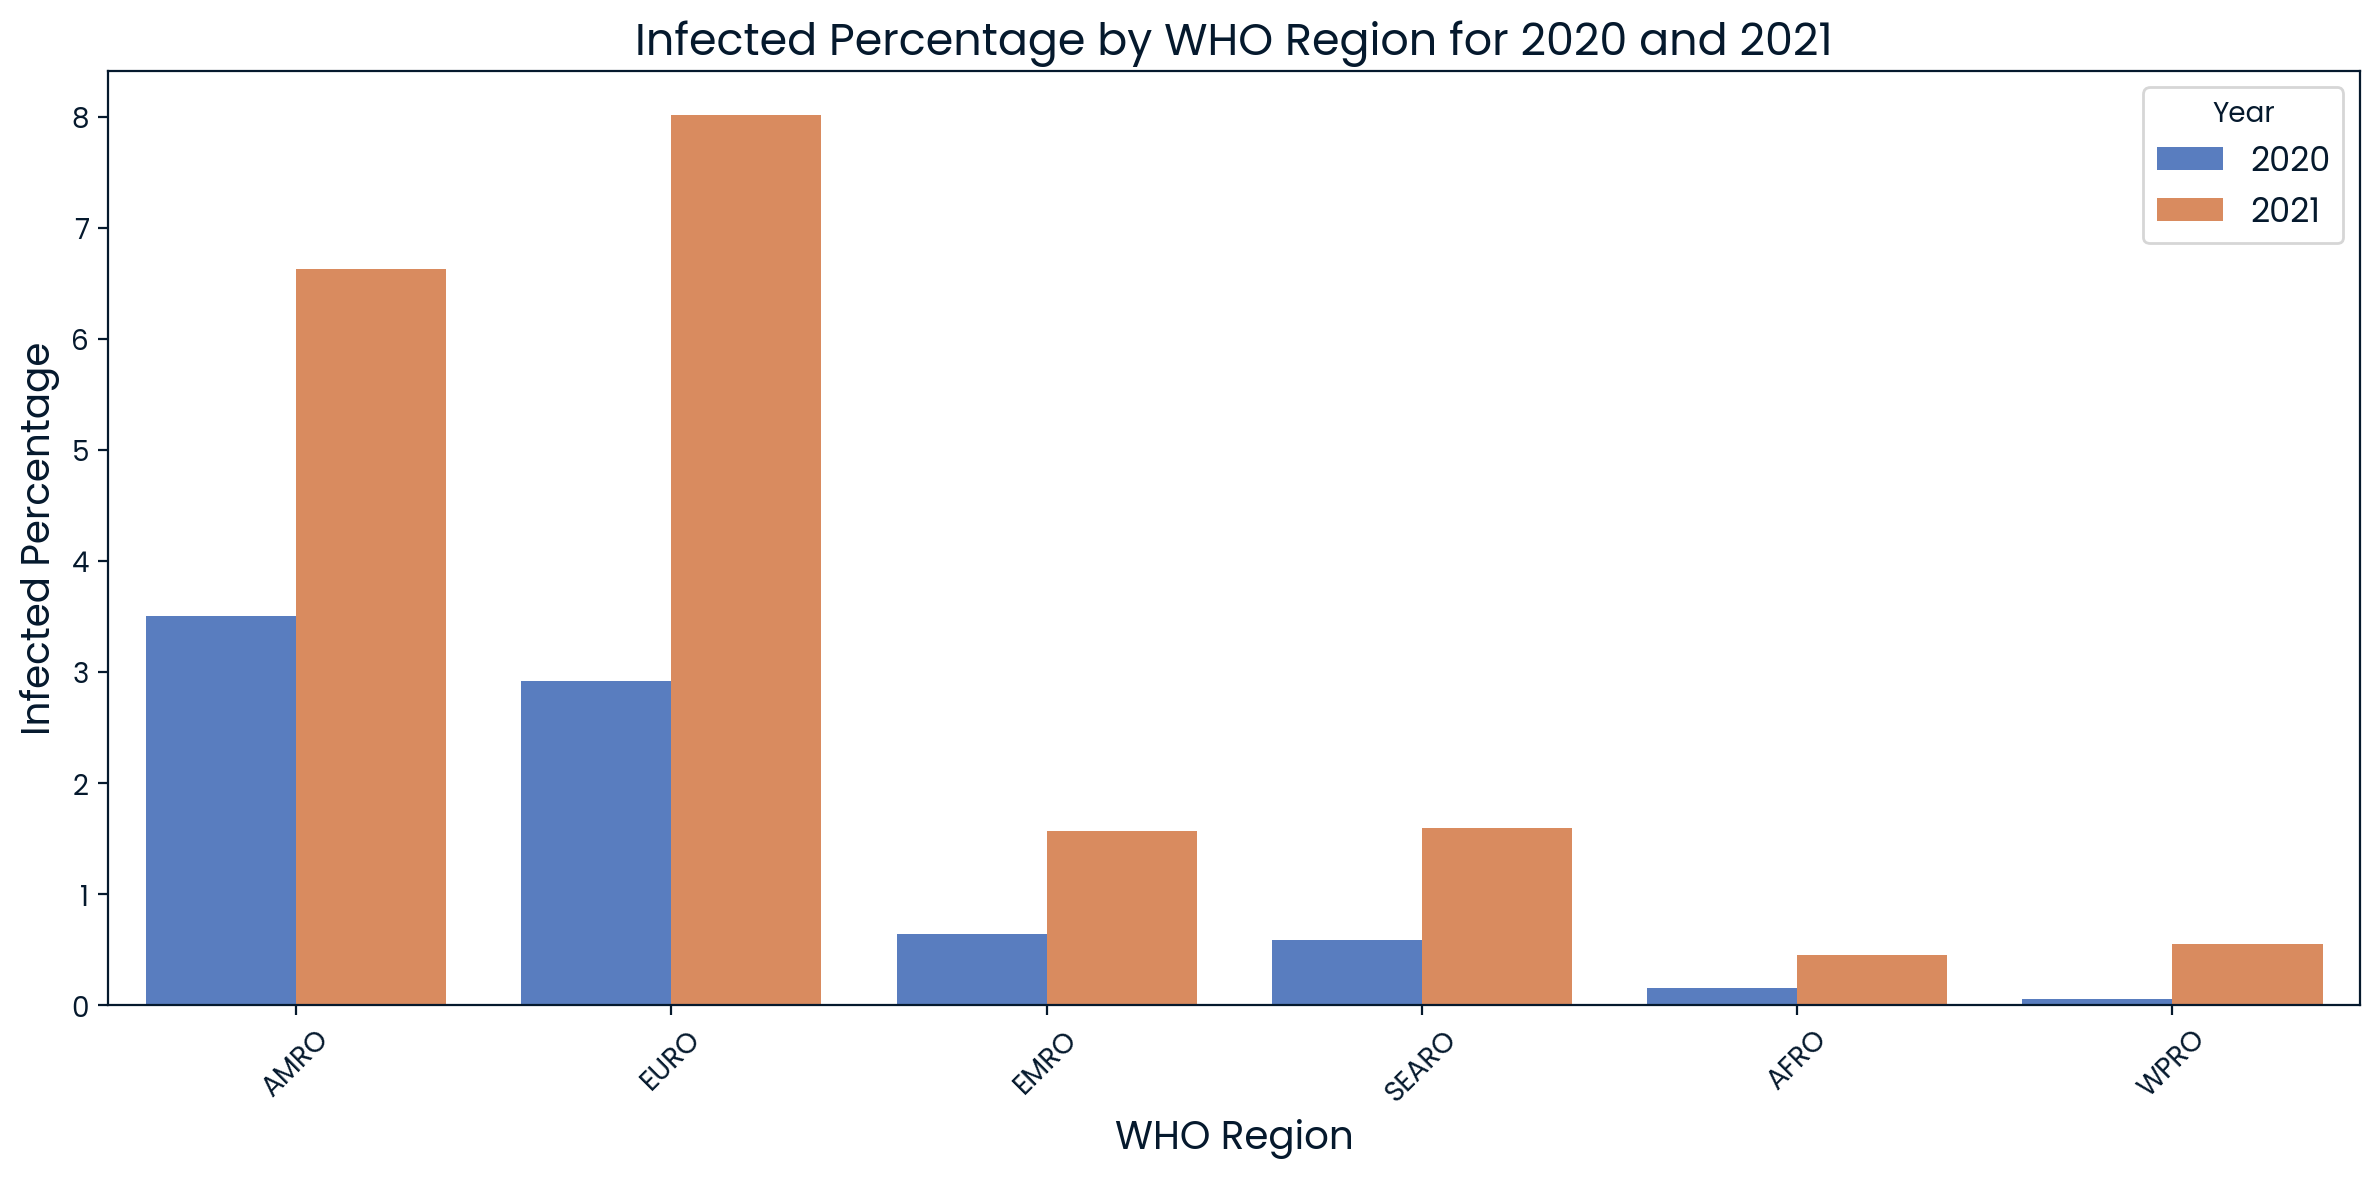

In [13]:
## To visualise Infected Percentage by WHO Region for 2020 and 2021

combined_df = pd.concat([
    result_2020[['WHO_region', 'Infected_Percentage']].assign(Year=2020),
    result_2021[['WHO_region', 'Infected_Percentage']].assign(Year=2021)
], axis=0).reset_index(drop=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=combined_df, x='WHO_region', y='Infected_Percentage', hue='Year', palette='muted')

plt.title('Infected Percentage by WHO Region for 2020 and 2021', fontsize=16)
plt.xlabel('WHO Region', fontsize=14)
plt.ylabel('Infected Percentage', fontsize=14)
plt.legend(title='Year', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()